In [1]:
%load_ext autoreload
%autoreload 2

In [4]:


import sys

sys.path.insert(0, 'nli/')

from plot import PlotResults

In [9]:
plots = PlotResults(
    models = ['avg_word_emb', 'uni_lstm'],
    versions = ['version_0', 'version_0'],
)

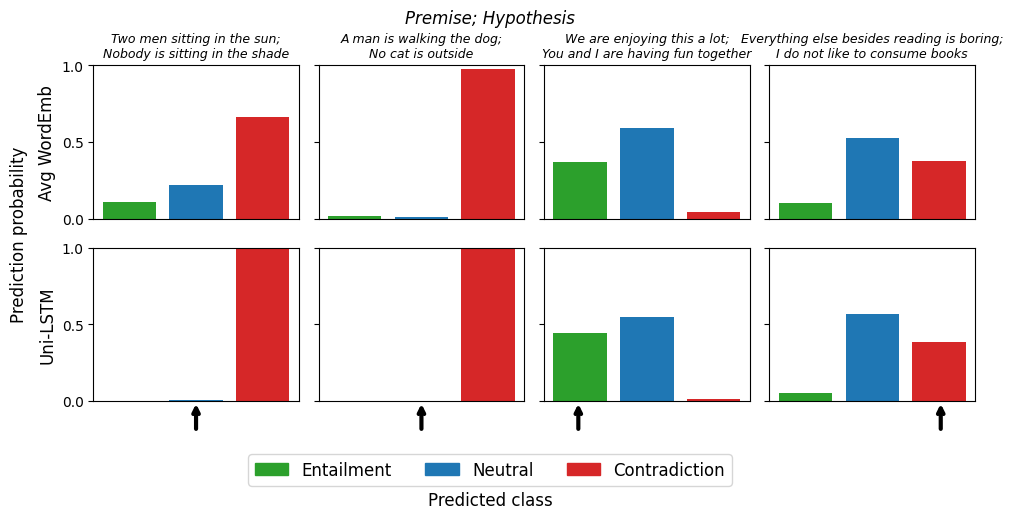

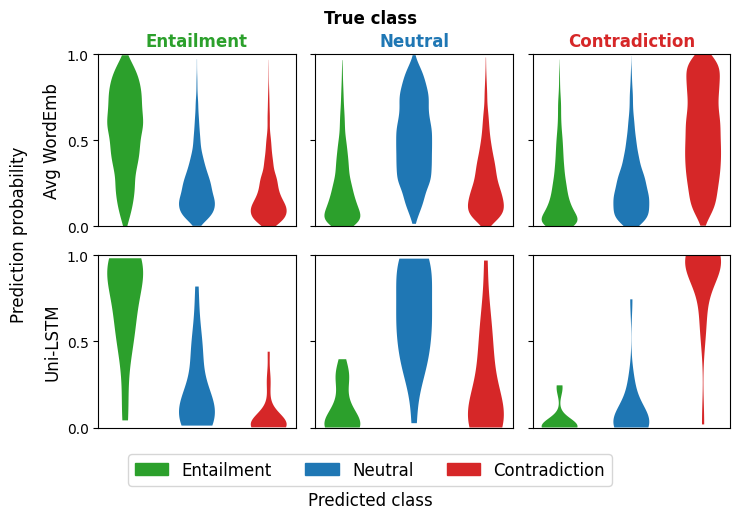

In [15]:
plots.plot_examples().show()

plots.plot_violin().show()